In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans


print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:

# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
image_shape = [h, w]
n_row, n_col = 2, 3
n_components = 150
rng = RandomState(0)

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
print("target_names:",target_names)
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# global centering
faces_centered = X - X.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)
print("Dataset consists of %d faces" % n_samples)


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
    

target_names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Dataset consists of 1288 faces


In [4]:
# Train a SVM classification model
def clf_train_and_predict(X_train,y_train,X_test,y_test,
                          name,estimator,target_names,labels,h,w):
    fitted_estimator = estimator.fit(X_train)
    X_train_t = fitted_estimator.transform(X_train)
    X_test_t = fitted_estimator.transform(X_test)
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(X_train_t, y_train)
    print("estimater:%s",name)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_t)
    print("done in %0.3fs" % (time() - t0))

    #for j in range(10):
    #    print(y_pred[j],y_test[j])
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred,labels=labels))
    
    prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

    plot_gallery(X_test, prediction_titles, h, w)

    # plot the gallery of the most significative eigenfaces


    plt.show()

In [5]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [6]:
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True)),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3)),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True)),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng,
                                      normalize_components=True)),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng)),


    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2)),
]


Extracting the top 150 Eigenfaces - PCA using randomized SVD...
Fitting the classifier to the training set
estimater:%s Eigenfaces - PCA using randomized SVD
done in 39.356s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.045s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.91      0.80      0.85        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       1.00      0.75      0.86        36

        micro avg       0

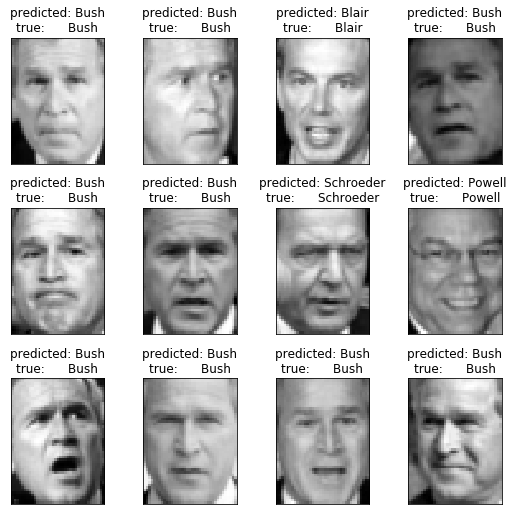

Extracting the top 150 Non-negative components - NMF...
Fitting the classifier to the training set


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


estimater:%s Non-negative components - NMF
done in 55.606s
Best estimator found by grid search:
SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.040s
                   precision    recall  f1-score   support

     Ariel Sharon       0.27      0.54      0.36        13
     Colin Powell       0.56      0.65      0.60        60
  Donald Rumsfeld       0.33      0.48      0.39        27
    George W Bush       0.76      0.58      0.66       146
Gerhard Schroeder       0.33      0.36      0.35        25
      Hugo Chavez       0.47      0.47      0.47        15
       Tony Blair       0.60      0.58      0.59        36

        micro avg       0.56      0.56      0.56       322
        macro avg       0.47      0.52      0.49       322
     weighted avg      

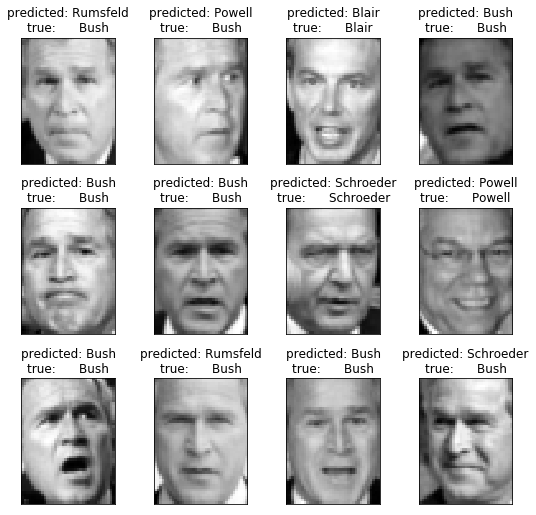

Extracting the top 150 Independent components - FastICA...
Fitting the classifier to the training set


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


estimater:%s Independent components - FastICA
done in 33.883s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.046s
                   precision    recall  f1-score   support

     Ariel Sharon       0.48      0.77      0.59        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.73      0.70      0.72        27
    George W Bush       0.96      0.87      0.91       146
Gerhard Schroeder       0.67      0.88      0.76        25
      Hugo Chavez       0.73      0.73      0.73        15
       Tony Blair       0.90      0.78      0.84        36

        micro avg       0.84      0.84      0.84       322
        macro avg       0.75      0.80      0.77       322
     weighted avg  

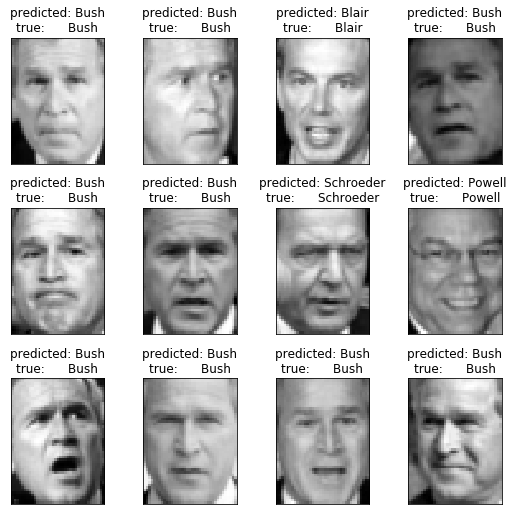

Extracting the top 150 Sparse comp. - MiniBatchSparsePCA...
Fitting the classifier to the training set
estimater:%s Sparse comp. - MiniBatchSparsePCA
done in 50.384s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.055s
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.00      0.00      0.00        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.45      1.00      0.62       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

        micro avg       0.45    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


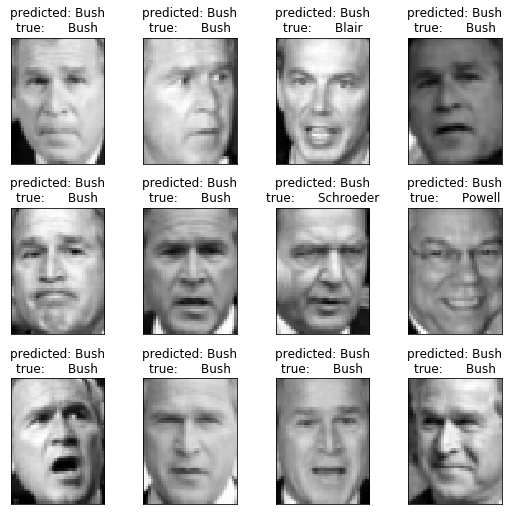

Extracting the top 150 MiniBatchDictionaryLearning...
Fitting the classifier to the training set
estimater:%s MiniBatchDictionaryLearning
done in 10.106s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.008s
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.00      0.00      0.00        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.45      1.00      0.62       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

        micro avg       0.45      0.45      

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


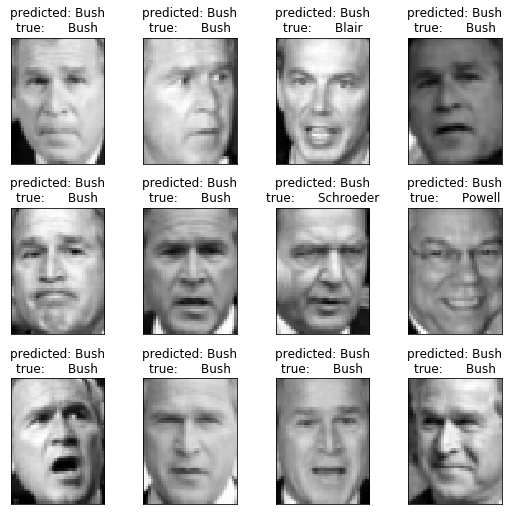

Extracting the top 150 Factor Analysis components - FA...


/usr/local/lib/python3.5/dist-packages/sklearn/decomposition/factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


Fitting the classifier to the training set
estimater:%s Factor Analysis components - FA
done in 43.898s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.043s
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.62      0.59        13
     Colin Powell       0.75      0.90      0.82        60
  Donald Rumsfeld       0.81      0.78      0.79        27
    George W Bush       0.94      0.90      0.92       146
Gerhard Schroeder       0.81      0.88      0.85        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.78      0.82        36

        micro avg       0.85      0.85      0.85       322
        macro avg       0.78      0.

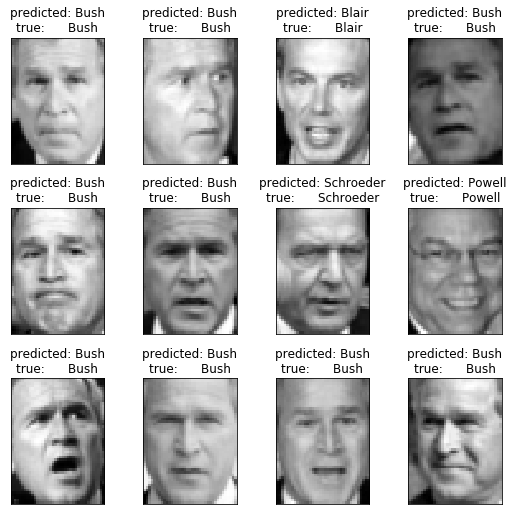

In [7]:
for name, estimator in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    clf_train_and_predict(X_train,y_train,X_test,y_test,
                          name,estimator,target_names,range(n_classes),h,w)